# Тестирование обобщающего NN-классификатора новообразований молочной железы

- [Матрицы ошибок](#Матрицы-ошибок)
- [Важность признаков](#Важность-признаков)

In [1]:
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf

from utils import neural_network as nn
from utils import definitions as defs
from utils import visualization as viz

In [2]:
generalizing_model = tf.keras.models.load_model(defs.GENERALIZING_MODEL)

entire_ds = nn.dataset_from_csv(defs.ENTIRE_DATA_PATH)
train_ds = nn.dataset_from_csv(defs.TRAIN_DATA_PATH)
val_ds = nn.dataset_from_csv(defs.VAL_DATA_PATH)
test_ds = nn.dataset_from_csv(defs.TEST_DATA_PATH)

## Матрицы ошибок

Построим матрицы ошибок с ещё одной меткой "не определён". Эта метку будем назначать в том случае, если ни для одной другой метки вероятность не превысила заданный порог. Порог будем перебирать.

In [3]:
def get_true_predicted_labels(threshold):
    """Возвращает истинные и предсказанные метки.
    
    Args:
        threshold: порог принятие решений.
    
    Returns:
        true_labels: истинные оценки.
        predicted_labels: предсказанные метки.
    """
    true_labels = []
    predicted_labels = []
    for point, true_probabilities in test_ds:
        true_label_index = np.array(true_probabilities[0]).argmax()
        true_label = defs.LABELS[true_label_index]
        true_labels.append(true_label)

        predicted_probabilities = generalizing_model.predict(point)
        best_predicted_probability = np.array(predicted_probabilities[0]).max()
        if best_predicted_probability < threshold:
            predicted_label = 'не определён'
        else:
            predicted_label_index = np.array(predicted_probabilities[0]).argmax()
            predicted_label = defs.LABELS[predicted_label_index]
        predicted_labels.append(predicted_label)

    return true_labels, predicted_labels

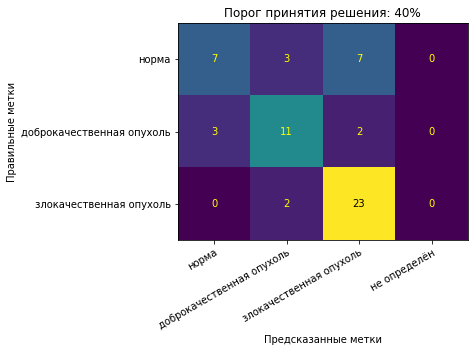

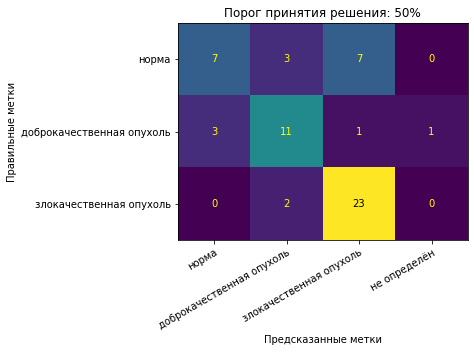

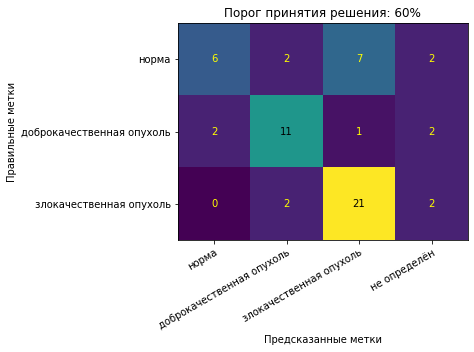

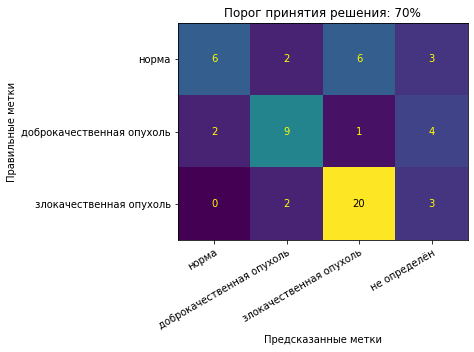

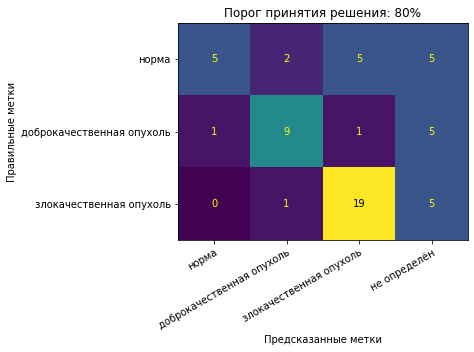

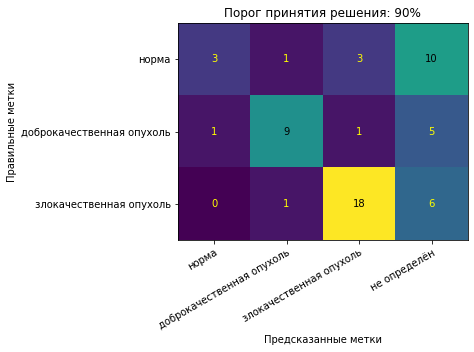

In [4]:
for threshold in [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    ys_true, ys_pred = get_true_predicted_labels(threshold)
    cm = viz.get_confusion_matrix(ys_true, ys_pred, defs.LABELS, defs.LABELS + ['не определён'])
    viz.plot_confusion_matrix(cm, defs.LABELS, defs.LABELS + ['не определён'], threshold=threshold)

## Важность признаков

In [5]:
defs.INPUT_NAMES.pop('label')

In [6]:
test_ds_evaluation = generalizing_model.evaluate(test_ds, verbose=0)[1]
print(f'Точность с учётом всех признаков: {test_ds_evaluation:2.2%}.')

Точность с учётом всех признаков: 70.69%.


In [7]:
def leave_features(features, dataset):
    """Зануляет все признаки, кроме заданных.

    Args:
        features: признаки, которые не зануляются.
        dataset: заданный датасет.

    Returns:
        dataset: обработанный датасет.
    """
    def zero_feature(point, label):
        """Зануляет признак в точке данных по его метке.

        Args:
            point: точка данных.
            label: метка признака, который необходимо занулить.

        Returns:
            point: точка данных с занулённым признаком.
            label: метка признака, который занулён.
        """
        if defs.INPUT_NAMES[feature_name] == 'numerical':
            point[feature_name] = tf.constant(
                np.array(0., dtype=np.float32),
                dtype=tf.float32,
                shape=(1,)
            )
        else:
            point[feature_name] = tf.constant(
                np.array(0, dtype=np.int32),
                dtype=tf.int32,
                shape=(1,)
            )
        return point, label

    for feature_name in defs.INPUT_NAMES.keys():
        if feature_name not in features:
            dataset = dataset.map(zero_feature)
            
    return dataset

In [8]:
def plot_accuracy_hist(combination_length):
    """Визуализирует гистограмму ...
    
    Args:
        combination_length: длина комбинации признаков.
    """
    i = 0
    for _ in itertools.combinations(range(32), combination_length):
        i += 1
    print(f'Количество комбинаций длиной {combination_length} из 32 = {i}.')
    
    evaluations = []
    for feature_names in itertools.combinations(defs.INPUT_NAMES.keys(), combination_length):
        test_ds_zeroed = leave_features(feature_names, test_ds)
        evaluation = 100 * generalizing_model.evaluate(test_ds_zeroed, verbose=0)[1]
        evaluations.append(evaluation)
        
    plt.hist(evaluations, bins=100, range=(0, 100))
    plt.show()

Количество комбинаций длиной 1 из 32 = 32.


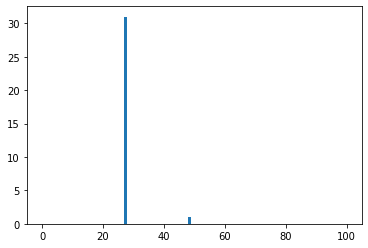

In [9]:
plot_accuracy_hist(1)

Количество комбинаций длиной 2 из 32 = 496.


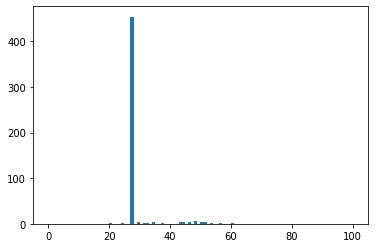

In [10]:
plot_accuracy_hist(2)

Количество комбинаций длиной 3 из 32 = 4960.


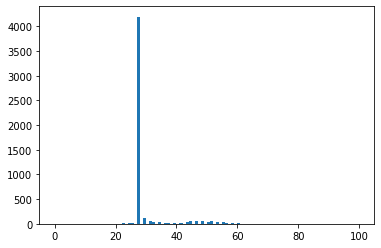

In [11]:
plot_accuracy_hist(3)

In [12]:
THRESHOLD = 0.3


def print_meaningful_combinations(combination_length):
    """Печатает список комбинаций признаков, точность классификации с которыми превысила 35%.
    
    Args:
        combination_length: длина комбинации признаков.
    """      
    results = []
    for feature_names in itertools.combinations(defs.INPUT_NAMES.keys(), combination_length):
        test_ds_zeroed = leave_features(feature_names, test_ds)
        evaluation = generalizing_model.evaluate(test_ds_zeroed, verbose=0)[1]
        if evaluation > THRESHOLD:
            results.append((feature_names, evaluation))
    
    print('Список значимых комбинаций:')
    for combination, evaluation in sorted(results, key=lambda x: x[1], reverse=True):
        print(f'{", ".join(combination)}: {evaluation:2.2%}')

In [13]:
print_meaningful_combinations(1)

Список значимых комбинаций:
input_2: 48.28%


In [14]:
print_meaningful_combinations(2)

Список значимых комбинаций:
input_2, input_7: 60.34%
input_2, input_4: 56.90%
input_2, input_32: 56.90%
input_2, input_10: 53.45%
input_2, input_11: 53.45%
input_2, input_15: 51.72%
input_2, input_25: 51.72%
input_2, input_27: 51.72%
input_2, input_29: 51.72%
input_2, input_22: 50.00%
input_2, input_24: 50.00%
input_2, input_31: 50.00%
input_2, input_6: 48.28%
input_2, input_12: 48.28%
input_2, input_13: 48.28%
input_2, input_14: 48.28%
input_2, input_17: 48.28%
input_2, input_19: 48.28%
input_2, input_23: 48.28%
input_2, input_3: 46.55%
input_2, input_16: 46.55%
input_2, input_18: 46.55%
input_2, input_26: 46.55%
input_2, input_28: 46.55%
input_2, input_5: 44.83%
input_2, input_9: 44.83%
input_2, input_33: 44.83%
input_2, input_20: 43.10%
input_2, input_30: 43.10%
input_2, input_35: 43.10%
input_22, input_31: 37.93%
input_2, input_34: 34.48%
input_19, input_22: 34.48%
input_19, input_27: 34.48%
input_22, input_33: 32.76%
input_11, input_22: 31.03%
input_22, input_27: 31.03%


In [15]:
print_meaningful_combinations(3)

Список значимых комбинаций:
input_2, input_4, input_7: 63.79%
input_2, input_4, input_24: 63.79%
input_2, input_7, input_10: 62.07%
input_2, input_7, input_27: 62.07%
input_2, input_29, input_32: 62.07%
input_2, input_4, input_25: 60.34%
input_2, input_4, input_29: 60.34%
input_2, input_5, input_7: 60.34%
input_2, input_7, input_16: 60.34%
input_2, input_7, input_23: 60.34%
input_2, input_7, input_29: 60.34%
input_2, input_11, input_13: 60.34%
input_2, input_4, input_11: 58.62%
input_2, input_4, input_12: 58.62%
input_2, input_4, input_13: 58.62%
input_2, input_4, input_15: 58.62%
input_2, input_4, input_27: 58.62%
input_2, input_4, input_28: 58.62%
input_2, input_6, input_7: 58.62%
input_2, input_7, input_13: 58.62%
input_2, input_7, input_15: 58.62%
input_2, input_7, input_17: 58.62%
input_2, input_7, input_18: 58.62%
input_2, input_7, input_25: 58.62%
input_2, input_7, input_26: 58.62%
input_2, input_7, input_31: 58.62%
input_2, input_7, input_33: 58.62%
input_2, input_10, input_11: